*Social Graphs and Interactions, Fall 2021, DTU*

# Final Project Notebook: Rick and Morty analysis

**"I don't do magic Morty, I do science. One takes brain, the other takes dark eyeliner" - Pickle Rick, S03E03**

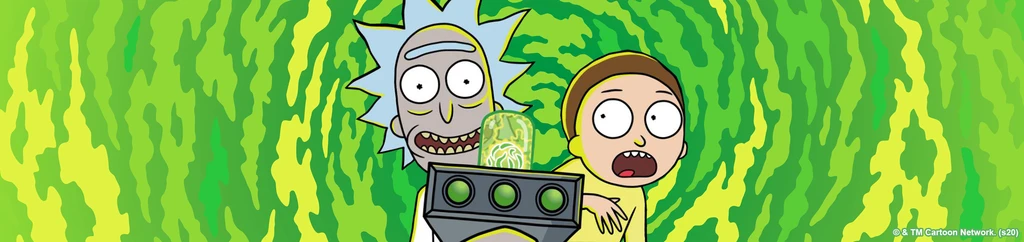


### TABLE OF CONTENTS

- [__1. Motivation__](#1.)
- [__2. Basic Stats__](#2.)
- [__3. Tools, theory and analysis__](#3.)
    - [3.1. <u>Communities</u>](#3.1.)
    - [3.2. <u>Centrality Analysis</u>](#3.2.)
    - [3.3. <u>Finding the “favourite words” of the Smith/Sanchez family</u>](#3.3.)
    - [3.4. <u>Wordclouds</u>](#3.4.)
    - [3.5. <u> Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?</u>](#3.5.)
    - [3.6. <u>Study Beth and Jerry marriage through seasons</u>](#3.6.)
    - [3.7. <u>Sentiment Analysis: Characters</u>](#3.7.)
    - [3.8. <u>Sentiment Analysis: Episode</u>](#3.8.)
    - [3.9. <u>Sentiment Analysis of Characters Through Episodes</u>](#3.9.)
- [__4. Discussion__](#4.)
- [__5. Contributions__](#5.)

---

<a id='1.'></a>
# 1. Motivation

*What is your dataset? Why did you choose this/these particular dataset(s)? What was your goal for the end user's?experience?*

Our dataset focus on Rick and Morty characters and how they relate to each other, based on Wiki pages hyperlink references like we did in the Zelda study case. We're also considering character's words through the analysis of transcripts, and characters' implication throughout episodes. 

We chose to study this universe because, first of all, we are all Rick and Morty show fans! Hence we felt very exciting to apply everything we went through in this Social Graphs & Interactions journey to this series.

More seriously, although Rick and Morty can be considered as a childhish crazy cartoon, tinged with an absurd humour and an assumed nonsense, we have to keep in mind that it is an adult series that deals with dark but deeply human topics, like loneliness, abandon, familial relationships, divorce or the death of loved ones.

Therefore, in the following study and with our website, we wanted to honour the great imagination of the two creators, Justin Roiland & Dan Harmon, by trying to better understand as the complexity as the richness of the social relationships depicted through Rick and Morty universe. 

<a id='2.'></a>
# 2. Basic Stats

*Write about your choices in data cleaning and preprocessing. Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)*

As previoulsy mentioned, our data is a combination of mainly the Wiki Rick and Morty page and an API that we used to extract additional information. First of all, we extracted the data from the Wiki page by using BeautifulSoup Python package. Once we obtained anything useful from the Wiki pages we tried to request data by using an API (if you want try to make a call on your browser to check the format: https://rickandmortyapi.com/api/character). We had a lot of issues when we tried to combined the two sources, since the API not only had quite more amount of data comparing to the Wiki page but also some of the names differed. For the transcripts and the episodes we used the dataset built by Andrada Olteanu from Kaggle. However, we did not stop there we obtained IMDB rating and ranking for the episodes.
You can find more information on our website in the section `Collect the Data, Morty`.


In [111]:
# import modules
import pandas as pd
import random as rd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import codecs
import networkx as nx
import urllib.request
import json
import nltk as tk
import matplotlib.pyplot as plt
import community
import fa2
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from os import listdir
from nltk.corpus import PlaintextCorpusReader
from os.path import isfile, join
from nltk.tokenize import WordPunctTokenizer
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from IPython.display import display
from scipy import stats
from collections import Counter
from community import community_louvain
from matplotlib.pyplot import figure
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


pd.options.mode.chained_assignment = None 
plt.rcParams["figure.figsize"] = (20,10)
sns.set()

In [3]:
# import our data
df_characters = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_characters_wRelationsAndAttributes_final.csv")
df_episodes = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_episodes.csv")
df_transcripts = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/transcripts/RickAndMortyScripts.csv")

# Dataframe of Characters
df_char_degr = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/df_characters_with_attr_and_communities.csv')
df_nrc = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/NRC.csv")
df_nrc_01 = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/lexicons/NRC_sentiment_lexicon.csv')



In [4]:
# toolbox
def rev_dict(aDict, rev=True):
    return dict(sorted(aDict.items(), reverse=rev, key=lambda x:x[1]))

In [5]:
# building the graph
def add_node(row, aGraph):
    """ Add the node given in row to global network """
    aGraph.add_node(row.Name, species=row.Species, origin=row.Origin, gender = row.Gender, status = row.Status)

def add_edges(row, aGraph):
    """ Add all edges which concern given character in row"""
    char_name = row.Name
    char_relations = ast.literal_eval(row.Relations)
    for aTargetRelation in char_relations:
        aGraph.add_edge(char_name,aTargetRelation)


In [6]:
# Create the associate graph with all attributes : role, race, genre, contentLength
G = nx.DiGraph()
_ = df_characters.apply(add_node, args=(G,), axis=1)
_ = df_characters.apply(add_edges, args=(G,), axis=1)

# Extract the Giant Connected Component, GCC
GCC = nx.weakly_connected_components(G)
GCC = list(GCC)
GCC.sort(key=len)
concerned_nodes = GCC[-1]
GCC = G.subgraph(concerned_nodes).copy()
G_copy = GCC.copy()

# make G undirected
GU = G.to_undirected()

In [7]:
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 514


In [8]:
print('Number of edges:', G.number_of_edges())

Number of edges: 1891


In [9]:
# store in and out degree
df_characters['in_degree'] = df_characters['Name'].map(dict(G.in_degree))
df_characters['out_degree'] = df_characters['Name'].map(dict(G.out_degree))

In [10]:
df_characters

,Name,Hyperlink,Relations,Species,Origin,Gender,Status,in_degree,out_degree
0,Abandoned Jerrys,https://rickandmorty.fandom.com/wiki/Abandoned...,['Jerry Smith'],Human,Earth,Male,Alive,0,1
1,Abrodolph Lincoler,https://rickandmorty.fandom.com/wiki/Abrodolph...,"['Rick Sanchez', 'Brad', 'Morty Smith', 'Nancy']",Human,unknown,Male,unknown,5,4
2,Adam,https://rickandmorty.fandom.com/wiki/Adam,[],Humanoid,Narnia Dimension,Male,Dead,0,0
3,Adjudicator Rick,https://rickandmorty.fandom.com/wiki/Adjudicat...,['Evil Morty'],Human,unknown,Male,Dead,1,1
4,Afro Rick,https://rickandmorty.fandom.com/wiki/Afro_Rick,"['Rick Sanchez', 'Morty Smith', 'Council of Ri...",Human,Earth (Dimension E-33),Male,Alive,2,7
...,...,...,...,...,...,...,...,...,...
509,Birdperson,https://rickandmorty.fandom.com/wiki/Birdperson,"['Rick Sanchez', 'Tammy Guterman', 'Squanchy',...",Bird Person,Bird World,Male,Alive,24,8
510,Memory Rick,https://rickandmorty.fandom.com/wiki/Memory_Rick,"['Birdperson', 'Rick Sanchez (Replacement Dime...",Sentient Memory (Human appearance),Birdperson's mind,Male,Alive,1,4
511,Chris,https://rickandmorty.fandom.com/wiki/Chris,"['Chris (The Ricks Must Be Crazy)', 'Shleemypa...",Alien,unknown,Genderless,Dead,3,2
512,Cynthia,https://rickandmorty.fandom.com/wiki/Cynthia,"['Cynthia (Rixty Minutes)', 'Prince Nebulon', ...",Zigerion,Zigerion,Female,Dead,1,3


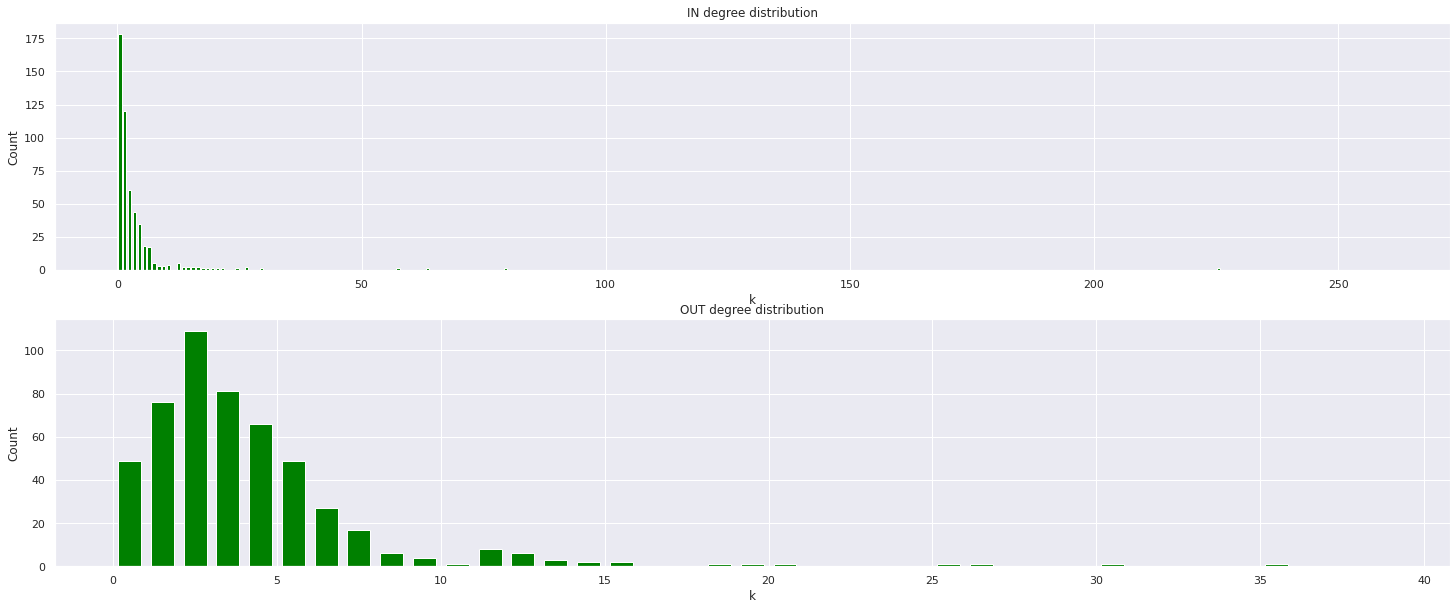

In [11]:
plt.figure(figsize=(25,10))
colors = ['green', 'blue', 'lime'] 

plt.subplot(211)
data = np.array(list(dict(G.in_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.in_degree()).values()))-min(list(dict(G.in_degree()).values()))), rwidth=0.7, color="green")
plt.title("IN degree distribution")
plt.ylabel("Count")
plt.xlabel("k")

plt.subplot(212)
plt.title("OUT degree distribution")
plt.ylabel("Count")
plt.xlabel("k")
data = np.array(list(dict(G.out_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.out_degree()).values()))-min(list(dict(G.out_degree()).values()))), rwidth=0.7, color="green")


plt.show()

In [12]:
nodes_species = {}
nodes_origin = {}
nodes_gender = {}
nodes_status = {}

for node in list(GU.nodes()):
    
    if not df_characters[df_characters["Name"] == node]["Species"].empty:
        nodes_species[node] = df_characters[df_characters["Name"] == node]["Species"].item()
        nodes_origin[node] = df_characters[df_characters["Name"] == node]["Origin"].item()
        nodes_gender[node] = df_characters[df_characters["Name"] == node]["Gender"].item()
        nodes_status[node] = df_characters[df_characters["Name"] == node]["Status"].item()
    else:
        nodes_species[node] = "unknown"
        nodes_origin[node] = "unknown"
        nodes_gender[node] = "Genderless"
        nodes_status[node] = "unknown"
    
    if nodes_gender[node] == "unknown":
        nodes_gender[node] = "Genderless"
    
nx.set_node_attributes(GU, nodes_species, "Species")
nx.set_node_attributes(GU, nodes_gender, "Gender")
nx.set_node_attributes(GU, nodes_origin, "Origin")
nx.set_node_attributes(GU, nodes_status, "Status")

In [13]:
G_to_draw = GU.copy()
G_copy = GCC.copy()
G_to_draw.remove_edges_from(nx.selfloop_edges(G_to_draw)) # remove self loops characters pointing to themselves 

In [14]:
# set node color and size 
get_color = {'Female':'orange','Genderless':'blue', "Male": "purple", "Both": "green"}

colors_list, size_list = [], []
for nodeName, nodeAttributes in list(G_to_draw.nodes(data=True)):
    # color nodes according to the role)
    colors_list.append(get_color[nodeAttributes['Gender']])
    # scale node-size according to degree
    size_list.append(G_to_draw.degree(nodeName))

size_list = list(20*np.array(size_list))
d = dict(GU.degree)

100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 374.80it/s]


BarnesHut Approximation  took  1.42  seconds
Repulsion forces  took  3.50  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


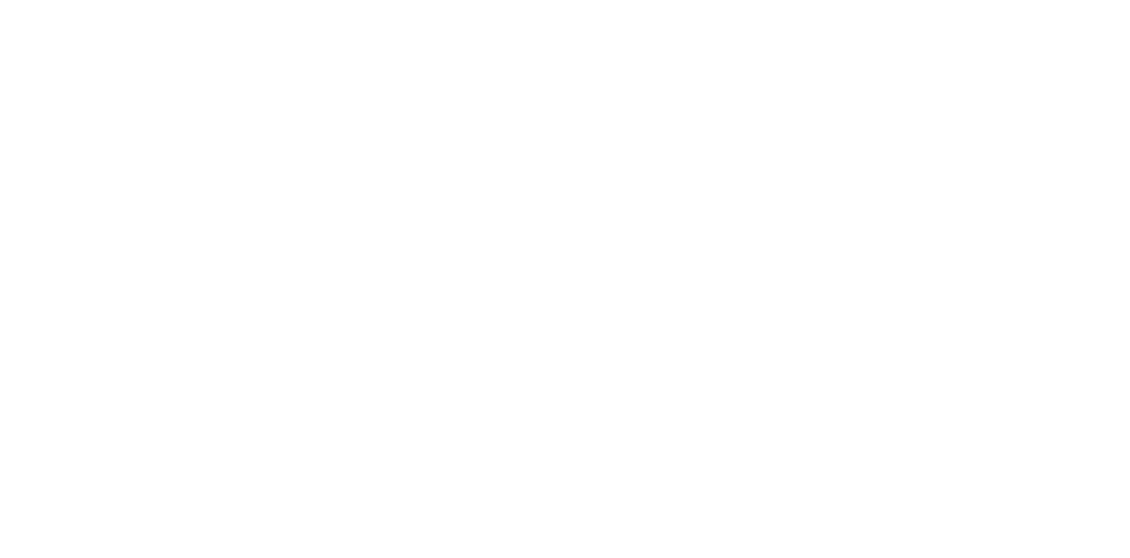

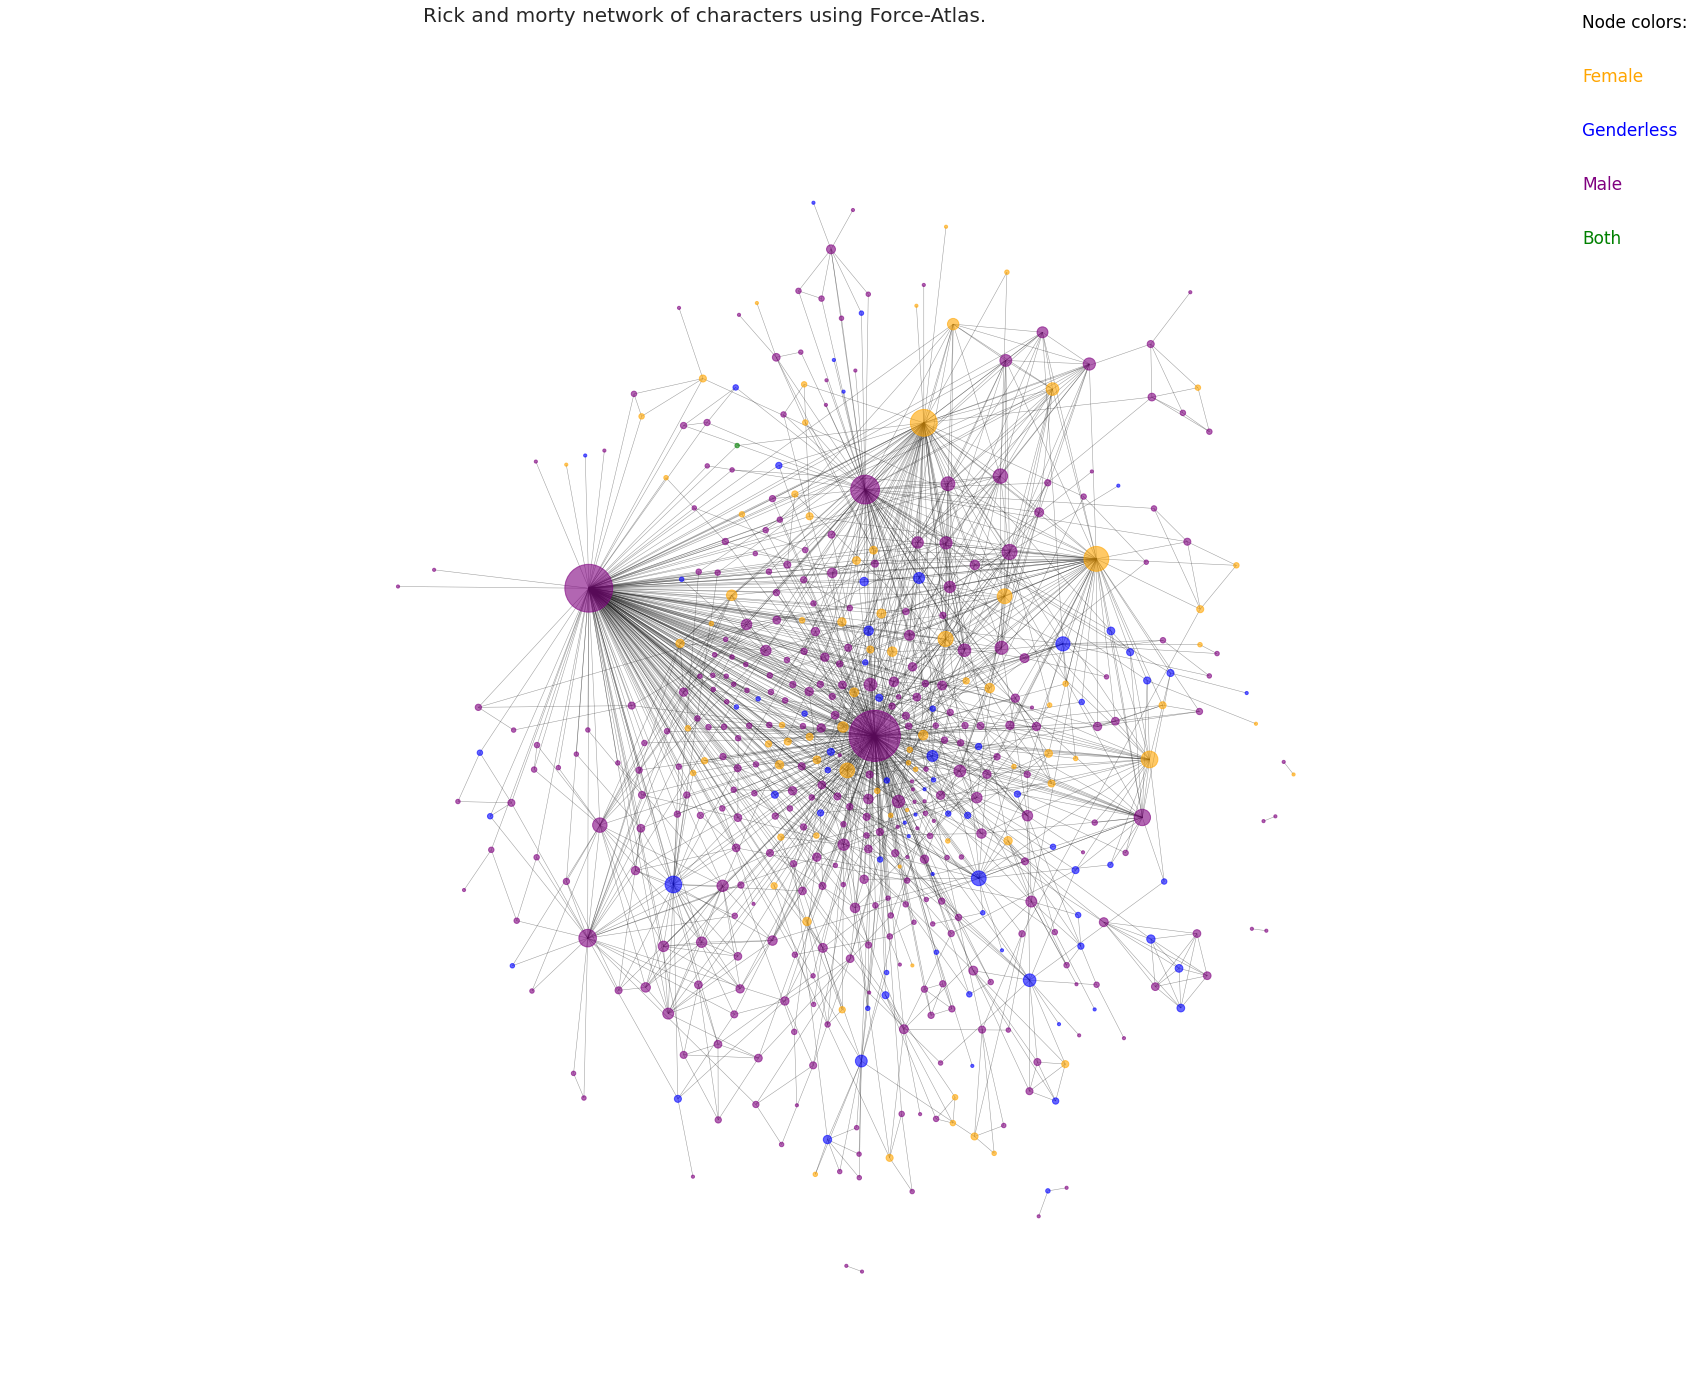

In [15]:
limits = plt.axis("off") 

forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False, 
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=70.0,
                        strongGravityMode=False,
                        gravity=400.0,

                        # Log
                        verbose=True)

# get node positions from force atlas
pos = forceatlas2.forceatlas2_networkx_layout(G_to_draw, pos=None, iterations=2000)

# plot network
plt.figure(figsize = [25, 25])

nx.draw_networkx_nodes(G_to_draw,pos=pos, node_size=[v*10  for v in d.values()], node_color=colors_list, alpha=0.6)
nx.draw_networkx_edges(G_to_draw,pos=pos, width=0.5, alpha=0.45, arrows=False)

plt.axis('off')

y = 0.88 # This is the starting y position for the figure legend
plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
colots_node = ['orange','blue', "purple", "green"]
role_node = ['Female', 'Genderless','Male', "Both"]
y -= 0.03
for i in range(4):
    plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
    y -= 0.03

plt.title("Rick and morty network of characters using Force-Atlas.", fontsize=20)

plt.show()

Text(0.5, 1.0, 'Scatter plot of in VS out degree for all characters')

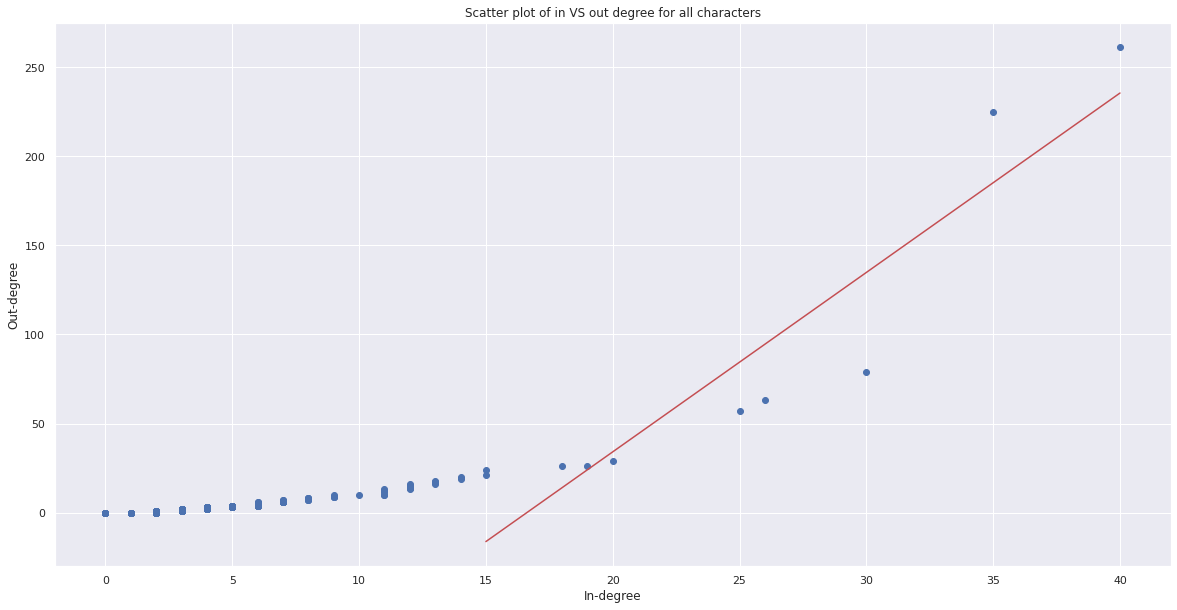

In [129]:
all_nodes = list(G.nodes())
x, y = [G.out_degree(aNode) for aNode in all_nodes],[G.in_degree(aNode) for aNode in all_nodes]
x.sort()
y.sort()
x_l, y_l = x[-9:], y[-9:]
res = stats.linregress(x_l, y_l)
x_l = np.array(x_l)

plt.plot(x, y, 'o', label='original data')
plt.plot(x_l, res.intercept + res.slope*x_l, 'r', label='fitted line')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.title('Scatter plot of in VS out degree for all characters')

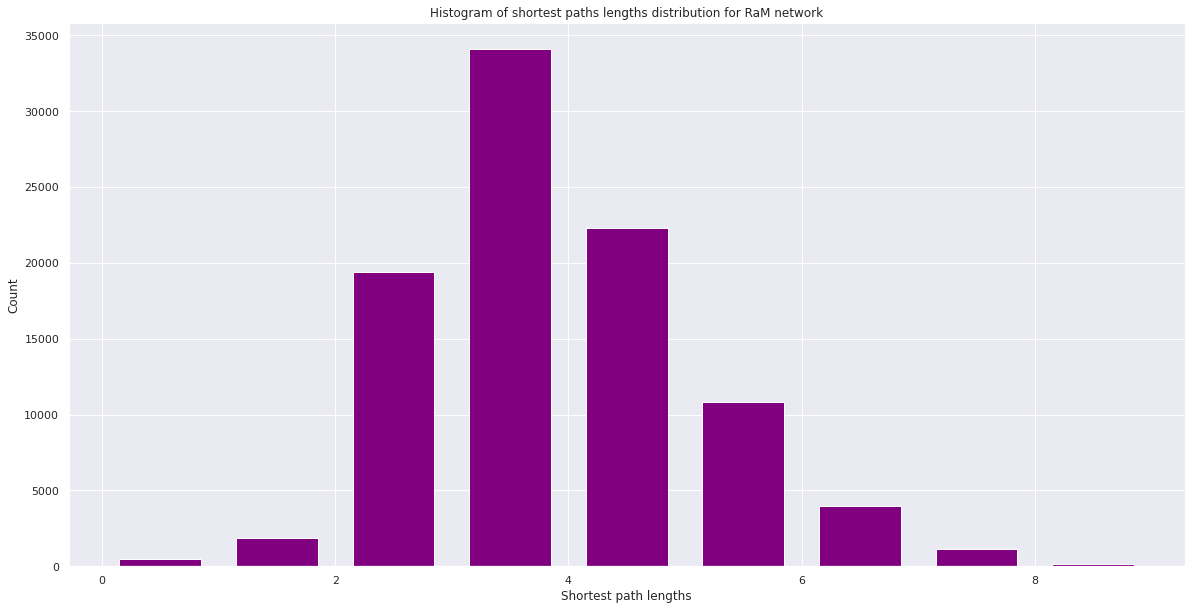

In [17]:
all_shortest_path_lengths = [int(e) for subDict in list(dict(nx.all_pairs_shortest_path_length(G)).values()) for e in list(subDict.values()) ]
plt.hist(all_shortest_path_lengths, bins=max(all_shortest_path_lengths)-min(all_shortest_path_lengths), color='purple', rwidth=0.7,)
plt.title('Histogram of shortest paths lengths distribution for RaM network')
plt.xlabel('Shortest path lengths')
plt.ylabel('Count')
plt.show()

In [121]:
fail_friendship_paradox = []
for _ in range (1000):
    i_rd = rd.choice(list(G_copy.nodes))
    d_rd = G.degree[i_rd]
    neighbors_list = list(G.neighbors(i_rd))
    neighbors_degree_list = [G.degree(neighbor) for neighbor in neighbors_list]
    avg_degree = np.mean(neighbors_degree_list)
    if avg_degree <= d_rd:
        fail_friendship_paradox.append((d_rd,avg_degree))
print(f"Friendship paradox works {100 - round(100*len(fail_friendship_paradox)/1000,2)}% of times")

Friendship paradox works 96.7% of times


<a id='3.'></a>
# 3. Tools, theory and analysis

<a id='3.1.'></a>
## 3.1. Communities 

*In network science we call a community a group of nodes that have a higher likelihood of connecting to each other than to nodes from other communities. Firstly, we created communities using the Louvain algorithm which looks for "small" communities by optimizing modularity in a local way. In addition, we create communities based on the node's attributes in order to explore a bit more our data. It is obvious that the modularity obtained in the communities that we created based on the node's attributes is smaller than the modularity of the Louvain algorithm*

In [56]:
best_partition = community_louvain.best_partition(GU)


def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

best_partition_subgraphs = get_partition_from_nodes_attributes(best_partition, G)

print(f"The partition based on Louvain-algorithm detects {len(list(best_partition_subgraphs.keys()))} communities.")


The partition based on Louvain-algorithm detects 60 communities.


In [57]:
print(f"The Louvain algorithm found {len(set(best_partition.values()))} communities for tthe network.\
The modularity is {community.modularity(best_partition, GU):.2f}")

The Louvain algorithm found 60 communities for tthe network.The modularity is 0.47


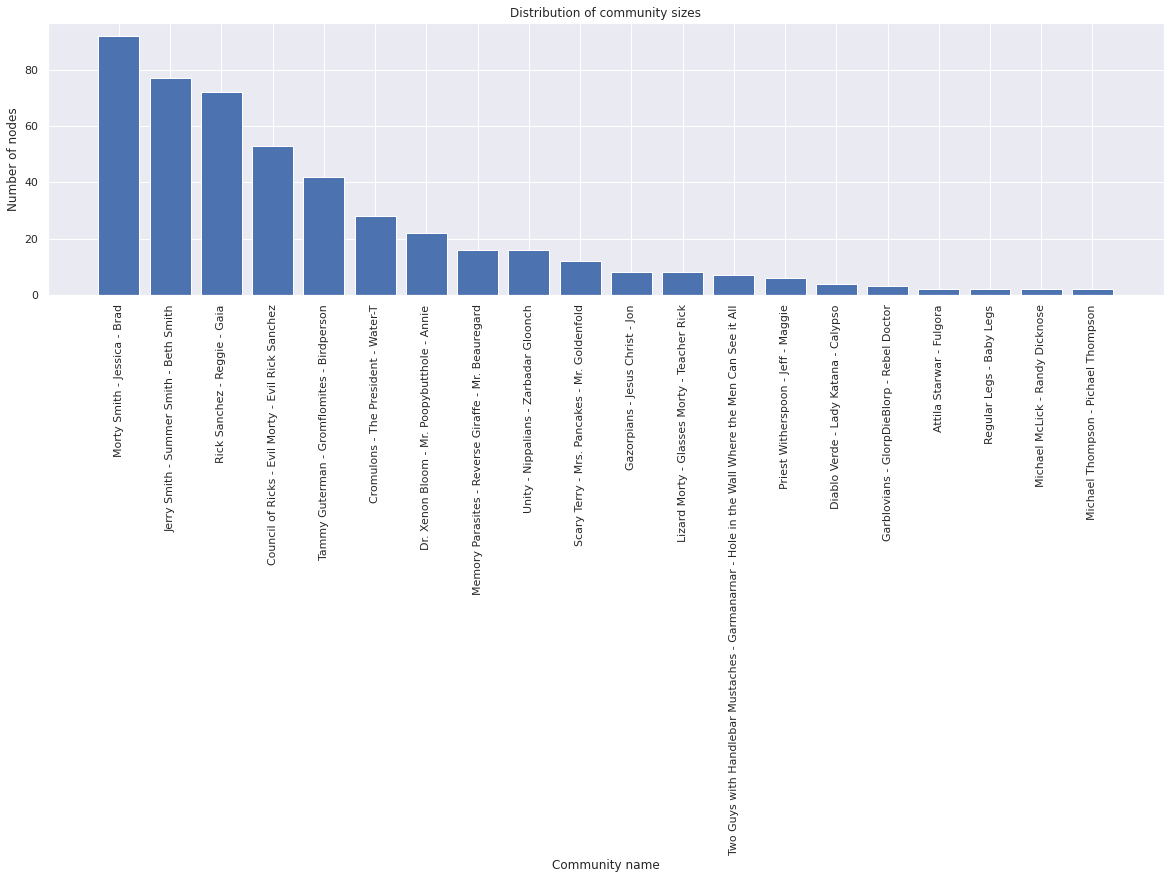

In [58]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in best_partition_subgraphs.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(best_partition.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))
best_partition_counter = {key:val for key, val in best_partition_counter.items() if val != 1}

# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values())
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes")
plt.show()


In [59]:
def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

def get_modularity(communities_dic, aGraph):
    """ Get the modularity M of the partition of a graph aGraph given through the dictionary of subgraphs communities_dic """
    L = aGraph.number_of_edges()
    M = 0
    for _, aCommunityGraph in communities_dic.items():
        Lc = aCommunityGraph.number_of_edges()
        kc = sum(list(dict(aCommunityGraph.degree).values()))
        M += (Lc/L - (kc/(2*L))**2)
    print("Modularity M = {}".format(round(M, 2)))
    return M

species_dict = pd.Series(df_characters.Species.values, index=df_characters.Name).to_dict()

part_comm_based_on_species = get_partition_from_nodes_attributes(species_dict, G)
print(f"The partition based on species detects {len(list(part_comm_based_on_species.keys()))} communities.")


print("For the partition based on species:")
species_partition_modularity = get_modularity(part_comm_based_on_species, G)

The partition based on species detects 34 communities.
For the partition based on species:
Modularity M = 0.35


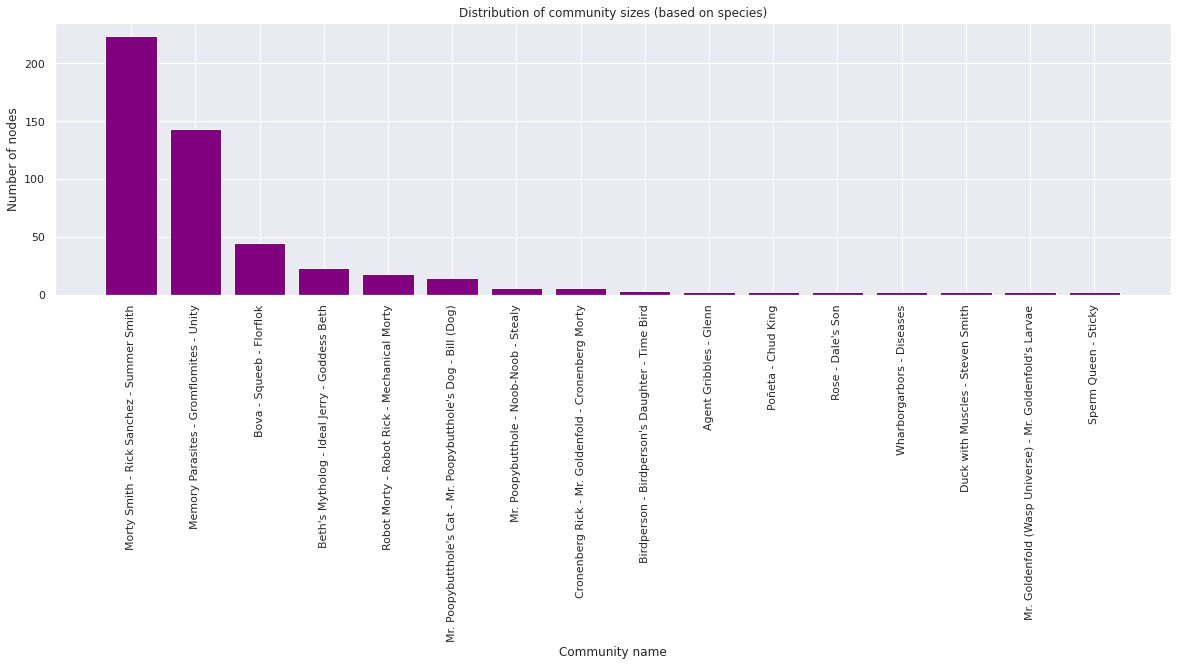

In [60]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in part_comm_based_on_species.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(species_dict.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))

best_partition_counter = {key:val for key, val in best_partition_counter.items() if val != 1}

best_partition_counter = {key:val for key, val in best_partition_counter.items() if key != 'unknown'}


# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values(), color='purple')
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes (based on species)")
plt.show()

In [61]:
origin_dict = pd.Series(df_characters.Origin.values, index=df_characters.Name).to_dict()

part_comm_based_on_origin = get_partition_from_nodes_attributes(origin_dict, G)
print(f"The partition based on origin detects {len(list(part_comm_based_on_origin.keys()))} communities.")


print("For the partition based on species:")
species_partition_modularity = get_modularity(part_comm_based_on_origin, G)

The partition based on origin detects 66 communities.
For the partition based on species:
Modularity M = 0.29


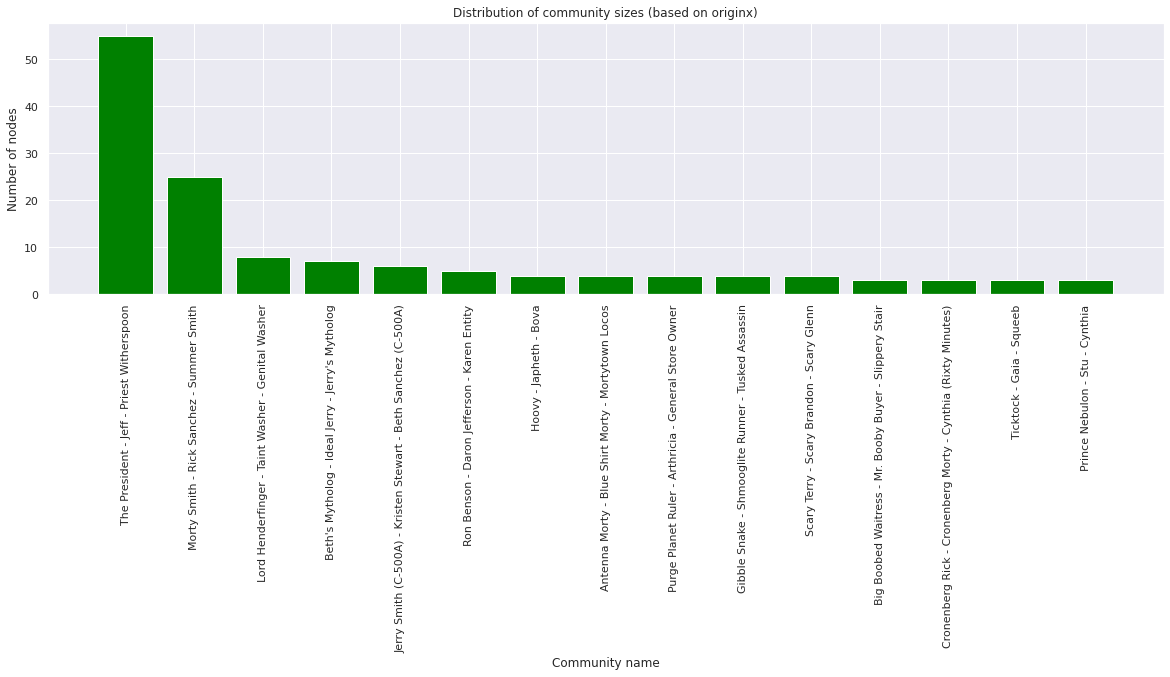

In [62]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in part_comm_based_on_origin.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(origin_dict.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))
best_partition_counter = {key:val for key, val in best_partition_counter.items() if val > 2 }
best_partition_counter = {key:val for key, val in best_partition_counter.items() if key != 'unknown'}


# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values(), color='green')
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes (based on originx)")
plt.show()

<a id='3.1.'></a>
## 3.2. Centrality Analysis

### Betweeness centrality

In [ ]:
N=10

# betweeness centrality
betweeness_centrality_dict = nx.betweenness_centrality(G)
betweeness_centrality_dict = dict(sorted(betweeness_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N, "most central characters according to betweeness centrality : ")
for i in range (N):
    character_name_i = list(betweeness_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {betweeness_centrality_dict[character_name_i]}")

### Eigenvector centrality

In [ ]:
eigenvector_centrality_dict = nx.algorithms.centrality.eigenvector_centrality(G)
eigenvector_centrality_dict = dict(sorted(eigenvector_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N,"most central characters according to eigenvector centrality : ")
for i in range (N):
    character_name_i = list(eigenvector_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {eigenvector_centrality_dict[character_name_i]}")

### Assortativity

In [ ]:
assort_coeffs = {}
attributes_list = ['species','gender','origin','status']

for a in attributes_list:
    assort_coeffs[a] =  nx.algorithms.assortativity.attribute_assortativity_coefficient(G, a)

assort_coeffs = rev_dict(assort_coeffs)

plt.bar(list(range(len(attributes_list))), assort_coeffs.values())
plt.xticks(list(range(len(attributes_list))), [k+f'\n({round(assort_coeffs[k],3)})' for k in assort_coeffs.keys()])
plt.xlabel("Attribute (assortativity coefficient)")
plt.ylabel('Assortativity score')
plt.title("Assortativity coefficients based on attributes")
plt.show()

<a id='3.3.'></a>
## 3.3.  Finding the “favourite words” of the Smith/Sanchez family

In [ ]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)



In [ ]:
rev_family_list = {v:k for k,v in family_list.items()}

In [ ]:
pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

stopwords = STOPWORDS
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = tk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])

In [ ]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = tk.Text(familyCorpus.words())

In [ ]:
# get the freq distribution of tokens
fdist_family = tk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of the {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

In [ ]:
def dic_reverse_sort(aDict, rev=True):
    return dict(sorted(aDict.items(), reverse=rev, key=lambda x:x[1]))

In [ ]:
familyText.similar('family')

In [ ]:
familyText.common_contexts(['family','important'])
familyText.common_contexts(['family','life'])

In [ ]:
# study each character's words
char_documents = {aCharacter:tk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}
char_documents

In [ ]:
# who is the most talkative
most_talkative = dic_reverse_sort({k:len(t)/len(familyText) for k,t in char_documents.items()})
most_talkative

In [ ]:
nb_lines = dic_reverse_sort({k:len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
nb_lines

In [ ]:
char_colors = {'Rick Sanchez':'#95e4f0', 'Morty Smith':'#f7ecb0','Jerry Smith':'#6fde8b','Summer Smith':'#e895de','Beth Smith':'#e8a2a2'}

In [ ]:
# plot most talkative : pie chart
plt.figure(figsize=(6,6))
font_color = 'k'
plt.pie(most_talkative.values(), 
           labels=['{} \n{}% of words\n({} lines)'.format(k,round(100*v),nb_lines[k]) for k,v in most_talkative.items()], 
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=[char_colors[k] for k in most_talkative.keys()],
           textprops={'color':font_color})
plt.title("Word repartition in the Smith family")
plt.show()

In [ ]:
# compare lexical diversities

# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

print("Overall lexical diversity: ", lexical_diversity(familyText))

compare_lexical_diversity = dic_reverse_sort({k:lexical_diversity(v) for k,v in char_documents.items()})
compare_lexical_diversity

In [ ]:
x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,compare_lexical_diversity.values(),color=[char_colors[k] for k in compare_lexical_diversity.keys()])
plt.xticks(x,[rev_family_list[k] for k in compare_lexical_diversity.keys()])
plt.title("Lexical diversity ratio per character")
plt.ylabel("Lexical diversity")
plt.show()

In [ ]:
# tokens/nb of lines
most_talkative2 = dic_reverse_sort({k:len(t)/len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
most_talkative2

x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,most_talkative2.values(),color=[char_colors[k] for k in most_talkative2.keys()])
plt.xticks(x,[rev_family_list[k] for k in most_talkative2.keys()])
plt.ylabel('Number of keywords/tokens')
plt.title("Average number of keywords/tokens per intervention")

plt.show()

In [ ]:
# get one document (of tokens) per character
char_documents = {aCharacter:tk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [ ]:
# compute the TC of each character
char_fdist = {aCharacter:tk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = tk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

In [ ]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [ ]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

<a id='3.4.'></a>
## 3.4.  Wordclouds

In [ ]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    """ 
    Generate N wordclouds (based on given chosen_elements) using 
    - documents_dic {aKey:aDocument},
    - TC_IDF_dic {aKey{aWord:aScore}},
    in the matplotlib.pyplot Figure (aFigure) with a fancy mask (aMaskFileName) if wanted
    """
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    # Adjust the number of occurrences of each word based on TC-IDF
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [ ]:
# get masks for plots
url_base_masks = "masks/"
all_masks = ["rick_blue.png", "morty_yellow.png", "beth_red.png", "jerry_green.png", 'summer_pink.png']
all_masks = [ url_base_masks+aMaskFileName for aMaskFileName in all_masks ]

In [ ]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the Smith Family", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<5:
        plot_wordcloud(list(family_list.values())[i], char_documents, family_TC_IDF, all_masks[i], ax)
    else:
        ax.set_visible(False)
plt.show()

In [ ]:
def get_50_most_frequent_bigrams_not_stopwords(aText, language = 'english', top_nb = 50):
    """Get  the 50 most most frequent bigrams of a text that are not stopwords. 
    By default, the text is in English"""
    # get the stopwords list in given language
    stopwords = tk.corpus.stopwords.words(language)
    # drop stopwords from text and punctuation
    content = tk.Text([w for w in aText if w.lower() not in stopwords and w.isalnum()])
    # get bigrams
    bigrams_list = list(tk.bigrams(content))
    # compute frequency distribution for bigrams
    fdist_bigrams = tk.FreqDist([a+' '+b for (a,b) in bigrams_list])
    # return 50 most common bigrams
    return fdist_bigrams.most_common(top_nb)


In [ ]:
for aCharacter in family_list.values():
    print("For "+aCharacter+' : ')
    print(get_50_most_frequent_bigrams_not_stopwords(char_documents[aCharacter], top_nb=5))

<a id='3.5.'></a>
## 3.5.  Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

Steps to follow:

    1. Create files with lines: a source to a target
    2. Tokenize
    3. Sentiment VADER method analysis for all lexicons
    4. Rankings and relationships comparisons: enough tokens, reciprocity

Compute interaction scores

To add:

   * Morty to Beth: 'mom'
   * Morty to Jerry: 'dad'
   * Beth to Rick: 'dad'
   * Summer to Jerry: 'dad'
   * Summer to Beth: 'mom'



In [ ]:
additional_targets_dict = {
    ('Morty','Beth'):'mom',
    ('Morty','Jerry'):'dad',
    ('Beth','Rick'): 'dad',
    ('Summer','Jerry'):'dad',
    ('Summer','Beth'):'mom'
}

In [ ]:
def get_df_substract(source_char, target_char):
    """ Get the dataframe of a source character talking to a target character"""
    return_df = df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))]
    if (source_char,target_char) in additional_targets_dict.keys():
        additionnal_appelation = additional_targets_dict[(source_char,target_char)]
        return_df = return_df.append(df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(additionnal_appelation, case=False))])
    return return_df


In [ ]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [ ]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ tk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText, aDF = None):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text """
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText, 'df':aDF}

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    df = get_df_substract(source_char, target_char)
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    df = df_transcripts[df_transcripts.name==source_char]
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def get_text_of(source,target=None):
    if target==None:
        df = df_transcripts[df_transcripts.name==source]
        return combine_lines(df)
    df = get_df_substract(source, target)
    return combine_lines(df)

Detail of VAD sentiments:

    valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
    arousal: from CALM/PASSIVE to EXCITED/ACTIVE
    dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

Detail of NRC sentiments: anger, fear, anticipation, trust, surprise, sadness, joy, or disgust

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# generate all lexicons
all_lexicons = {}
for element in ['Arousal','Dominance','Valence']:
    all_lexicons[element]= {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC_VAD[['Word',element]].iterrows()}
for element in df_NRC.drop('Word',axis=1).columns:
    all_lexicons[element] = {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC[['Word',element]].iterrows()}
all_lexicons['Valence_VADER']= SentimentIntensityAnalyzer().lexicon

**For interactions 'source', 'target'**

In [ ]:
# [Source, Target, Nb_tokens, Valence, Arousal, Dominance, Anger, Fear, Anticipation, Trust, Surprise, Sadness, Joy, Disgust]
# VADER METHOD
interactions_sentiment_scores = []

for aSourceChar in family_list.keys():
    print('Processing...', aSourceChar)
    for aTargetChar in family_list.keys():
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            aRow = [aSourceChar, aTargetChar, nb_tokens]
            for aSentiment, aLexicon in all_lexicons.items():
                print('   Sentiment: ', aSentiment)
                analyzer.lexicon = aLexicon
                polarity_score = analyzer.polarity_scores(results['lines'])
                aRow.append(polarity_score['compound'])
            interactions_sentiment_scores.append(aRow)

# to dataframe
df_family_interactions = pd.DataFrame(interactions_sentiment_scores,columns=['Source','Target','Nb_tokens']+list(all_lexicons.keys()))
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens>0]

In [ ]:
df_family_interactions = pd.read_csv('family_interactions_sentiment_scores.csv')
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens > 100]

In [ ]:
df_family_interactions.drop('Nb_tokens',axis=1).sort_values(['Source','Target'])

In [ ]:
def get_interactions_comparison(aSentiment):
    # get the sub df for given sentiment
    df_sentiment = df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']]
    # compute interactions comparison in a dict
    sentiment_dict = {}
    for i in range (len(family_list.keys())):
        for j in range (i+1,len(family_list.keys())):
            aTarget, aSource = list(family_list.keys())[i], list(family_list.keys())[j]
            if aTarget != aSource:
                df_temp1 = df_sentiment[(df_sentiment.Source == aSource) & (df_sentiment.Target == aTarget)]
                df_temp2 = df_sentiment[(df_sentiment.Source == aTarget) & (df_sentiment.Target == aSource)]
                if len(df_temp1)>0 and len(df_temp2)>0:
                    score1, score2 = list(df_temp1[aSentiment])[0],list(df_temp2[aSentiment])[0]
                    diff = (score1-score2)
                    if diff <0:
                        char_max, char_less = "{} ({})".format(aTarget, score2), "{} ({})".format(aSource, score1)
                    else:
                        char_max, char_less = "{} ({})".format(aSource, score1), "{} ({})".format(aTarget, score2)
                    sentiment_dict[char_max,char_less]=abs(diff)
    return dic_reverse_sort(sentiment_dict, rev=False)

def get_top5_bottom5(aSentiment, n=5):
    df_sentiment = get_top5(aSentiment, n)
    df_sentiment = df_sentiment.append(get_bottom5(aSentiment, n))
    return df_sentiment.sort_values(aSentiment, ascending=False, axis=0)

def get_top5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def get_bottom5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=True)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def plot_interactions_comparison(aSentiment):
    sentiment_dict = get_interactions_comparison(aSentiment)
    # plot
    x = list(range(len(sentiment_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x,sentiment_dict.values())
    plt.yticks(x,sentiment_dict.keys())
    plt.title("{} relationship variations in the Smith family".format(aSentiment))
    plt.xlabel("Absolute Variation of {} Score".format(aSentiment))
    plt.show()

def plot_top5_bottom5(aSentiment, n=5):
    top5_bottom5 = get_top5_bottom5(aSentiment, n)
    top5_bottom5_dict = {'{} to {}'.format(aRow.Source, aRow.Target):aRow[aSentiment] for _,aRow in top5_bottom5.iterrows()}
    top5_bottom5_dict = dic_reverse_sort(top5_bottom5_dict, rev=False)
    # plot
    x = list(range(len(top5_bottom5_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x[n:],list(top5_bottom5_dict.values())[n:],label='Top {}'.format(n))
    plt.barh(x[:n],list(top5_bottom5_dict.values())[:n],label='Bottom {}'.format (n))
    plt.yticks(x,top5_bottom5_dict.keys())
    plt.title("Top-{} and Bottom-{} for {} relationships in the Smith family".format(n,n,aSentiment))
    plt.xlabel("{} Score".format(aSentiment))
    plt.legend()
    plt.show()

def get_stats(aSentiment):
    return df_family_interactions[aSentiment].describe().to_frame().T

In [ ]:
df_family_interactions.drop('Nb_tokens',axis=1).describe()

In [ ]:
sentiment = 'Valence_VADER'
plot_top5_bottom5(sentiment, 4)
display(get_stats(sentiment))
plot_interactions_comparison(sentiment)

In [ ]:
analyse_interactions_NRC('Morty','Summer')['VAD scores']

In [ ]:
analyse_interactions_NRC('Summer','Morty')['VAD scores']

In [ ]:
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon = all_lexicons['Arousal']
print(analyzer.polarity_scores(get_text_of('Summer','Morty')))
print(analyzer.polarity_scores(get_text_of('Morty','Summer')))

In [ ]:
get_text_of('Morty','Beth')

In [ ]:
get_text_of('Morty','Summer')

**For each character individually : irrelevant**

In [ ]:
# save as csv
df_family_individual_sentiment_scores.to_csv('family_individual_sentiment_scores.csv',index=False)

In [ ]:
df_family_individual_sentiment_scores = pd.read_csv('family_individual_sentiment_scores.csv')

In [ ]:
# Other metrics
interactions_other_scores = []

for aSourceChar in family_list.keys():
    for aTargetChar in family_list.keys():
        results_perso = analyse_one_char_words(aSourceChar)
        nb_tokens_total = len(results_perso['tokens'])
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            if nb_tokens > 100 :
                nb_interrogations = results['lines'].count('?')
                nb_exclamations = results['lines'].count('!')
                nb_egocentric = results['lines'].lower().count('i')+results['lines'].lower().count('me')+results['lines'].lower().count('my')
                nb_you = results['lines'].lower().count('you')
                aRow = [aSourceChar, aTargetChar, nb_tokens, nb_tokens/nb_tokens_total, nb_interrogations/nb_tokens, nb_exclamations/nb_tokens, nb_egocentric/nb_tokens, nb_you/nb_tokens]
                interactions_other_scores.append(aRow)

# to dataframe
df_interactions_other_scores = pd.DataFrame(interactions_other_scores,columns=['Source','Target','Nb_tokens','Ratio', 'Interrogation','Exclamation','Egocentric','You'])

In [ ]:
df_interactions_other_scores.sort_values('Egocentric',ascending=False)

In [ ]:
sentiment_focus = 'Dominance'
df_NRC_VAD[df_NRC_VAD.Word.isin(results['tokens'])].sort_values(sentiment_focus, ascending=False)[['Word',sentiment_focus]]

<a id='3.6.'></a>
## 3.6.  Study Beth and Jerry marriage through seasons

In [ ]:
def add_line_to_season(aRow):
    seasons_strings[aRow['season no.']] += aRow['line']

seasons_strings = {k:'' for k in range (1,6)}

for aSeason in range(1,6):
    df_season = df_transcripts[df_transcripts['season no.']==aSeason]
    _ = df_season.apply(add_line_to_season, axis=1)

In [ ]:
# create NLTK objects: Corpus and Text
corpus_root = 'transcripts/per_season'
all_files = [f for f in listdir(corpus_root) if isfile(join(corpus_root, f))]
seasonCorpus = PlaintextCorpusReader(corpus_root, all_files)
seasonText = tk.Text(seasonCorpus.words())

In [ ]:
seasonText.dispersion_plot(["parents","divorce"])

In [ ]:
seasonText.concordance('divorce')

In [ ]:
seasonText.similar("divorce")

In [ ]:
# get one document per season
season_documents = {aSeason:tk.Text(seasonCorpus.words(['S0'+str(aSeason)+'.txt'])) for aSeason in seasons_strings.keys()}
season_documents

In [ ]:
cfd_seasons = tk.ConditionalFreqDist(
    (target, aSeason) 
    for aSeason in range(1,6)
    for w in seasonCorpus.words(['S0'+str(aSeason)+'.txt'])
    for target in ['rick']
    if w.lower().startswith(target)
)

plt.figure(figsize=(18,7))
plt.title("Conditional Frequency Distribution of 'divorce' words in the transcripts over seasons")
_ = cfd_seasons.plot()

<a id='3.7.'></a>
## 3.7.  Sentiment Analysis: Characters

In [63]:
# Replacing the names of some characters at df_transcripts to match the names in df_characters
df_transcripts["name"].replace({"Rick": "Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Evil Rick": "Evil Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Pickle Rick": "Pickle Rick (character)"}, inplace=True)
df_transcripts["name"].replace({"Morty": "Morty Smith"}, inplace=True)
df_transcripts["name"].replace({"Beth": "Beth Smith"}, inplace=True)
df_transcripts["name"].replace({"Jerry": "Jerry Smith"}, inplace=True)
df_transcripts["name"].replace({"Summer": "Summer Smith"}, inplace=True)
df_transcripts["name"].replace({"'Rick D716-B": "Rick D716-B"}, inplace=True)

In [64]:
# A dataframe with all the lines of each character
df_charLines = df_transcripts.groupby(['name'], as_index = False).agg({'line': ' '.join})
#Remove stopwords
df_charLines.line = df_charLines.line.apply(lambda x: remove_stopwords(x))

In [65]:
# A dictionary with all the lines of each character
characters_dialogue = df_charLines.set_index('name').T.to_dict('records')[0]

In [69]:
def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ tk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    #Combine in a dict the weight of sentiments for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d

In [71]:
# Calculate the NRC sentiment score for each character

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_a_character(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        #print([calculate_nrc_sentiments(get_list_of_tokens(aSentence)) for aSentence in characters_dialogue[aRow.Name]])
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(characters_dialogue[aRow.Name]))
        
        count = 0
        for word in get_list_of_tokens(characters_dialogue[aRow.Name]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)



_ = df_characters.apply(calculate_NRC_sentiment_of_a_character, axis=1)

# store in dataframe of characters as a new column
df_characters['NRC_score'] = sentiment_NRC_list
df_characters['NRC_words'] = count_list
df_NRC = df_characters[df_characters.NRC_score.notnull()]   # df_NRC.count() = 80
df_NRC = df_NRC[df_NRC.NRC_words != 0]

In [72]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_a_character(aRow):
        
    dictChar = df_NRC[df_NRC.Name == aRow.Name]['NRC_score'].values[0]
    
    positive = dictChar['positive'] + dictChar['trust'] + dictChar['anticipation'] + dictChar['joy'] + dictChar['surprise']
    negative = dictChar['negative'] + dictChar['fear'] + dictChar['anger'] + dictChar['disgust'] + dictChar['sadness']
    keys = list(dictChar.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictChar[k] for k in keys}
    
    count = df_NRC[df_NRC.Name == aRow.Name]['NRC_words'].values[0]
            
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


    
_ = df_NRC.apply(calculate_NRC_portions_of_a_character, axis=1)

# store in dataframe of characters as a new column
df_NRC['Positive'] = positive_list
df_NRC['Positive_portion'] = positive_portion_list
df_NRC['Negative'] = negative_list
df_NRC['Negative_portion'] = negative_portion_list
df_NRC['Emotions'] = NRC_emotions_list
df_NRC['Emotions_portion'] = NRC_emotions_portion_list

In [73]:
def sort_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}

In [74]:
# Plots for each character's sentiments
   
def piechart_characters_sentiments(name):
    
    labels = 'Positive', 'Negative'
    sizes = [df_NRC[df_NRC.Name == name]['Positive'].values[0], df_NRC[df_NRC.Name == name]['Negative'].values[0]]
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title(name + ': Sentiments')

    
    
def plot_seaborn_character_emotions(name):

    #keys = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise'] # emotions
  
    d = df_NRC[df_NRC.Name == name]['Emotions_portion'].tolist()[0]
    #d = {k: v for k, v in d.items() if k in keys}
    d = sort_dict(d)
    f, ax = plt.subplots()   #, sharex=True)
    y = list(d.keys())
    x = list(d.values())  # weight 
    #x = list(map(d.get, y)) # weight 
    sns.set(rc = {'figure.figsize':(5,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Percentage (%)')
    ax.invert_yaxis()  # labels read top-to-bottom
    #ax.set_title('Sentiment Analysis: ' + name)
    #count_words = df_NRC[df_NRC.Name == name]['NRC_words_count'].values[0]
    count_words = df_NRC[df_NRC.Name == name]['NRC_words'].values[0]
    ax.set_title(name + ': Emotions')
    #ax.set_title(name + ': Emotions  (' + str(count_words) + ' NRC words)')
    ax.set_xlim([0, 50])
    ax.invert_yaxis() 


(None,)

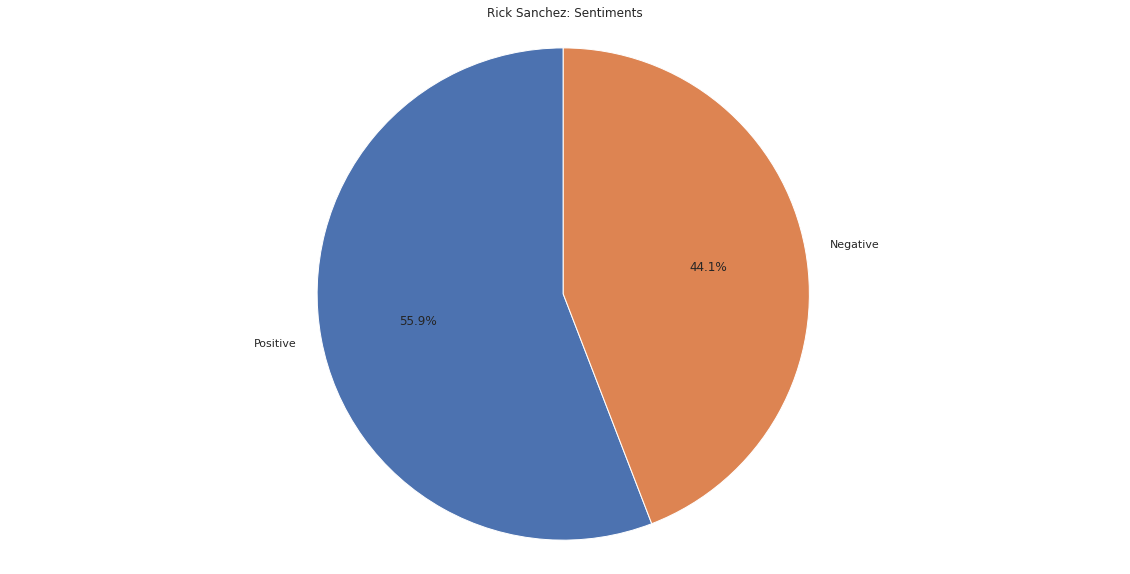

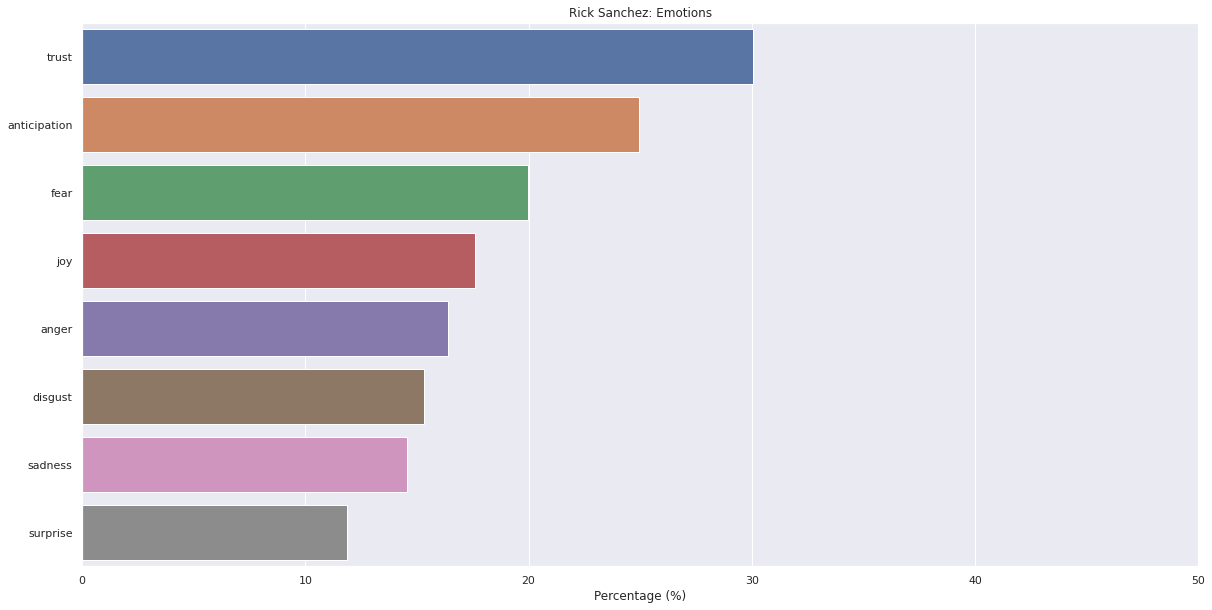

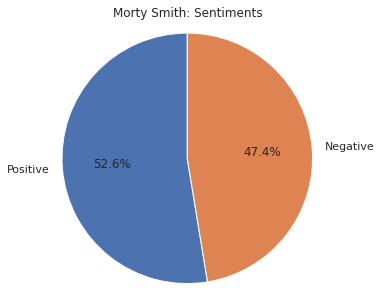

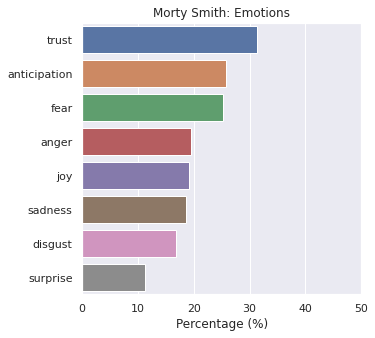

In [75]:
piechart_characters_sentiments('Rick Sanchez'),
plot_seaborn_character_emotions('Rick Sanchez')
piechart_characters_sentiments('Morty Smith'),
plot_seaborn_character_emotions('Morty Smith'),
# piechart_characters_sentiments('Summer Smith'),
# plot_seaborn_character_emotions('Summer Smith'),
# piechart_characters_sentiments('Beth Smith'),
# plot_seaborn_character_emotions('Beth Smith')
# piechart_characters_sentiments('Jerry Smith'),
# plot_seaborn_character_emotions('Jerry Smith')

**Top characters for each sentiment**

In [76]:
# Filtering df_NRC to keep only those with more than 10 nrc words
df_NRC_filtered = df_NRC[df_NRC.NRC_words > 50]

sent_dict = {}

def a_sentiment_for_a_character(aRow, sentiment):
    if sentiment == 'positive':
        sent_dict[aRow.Name] = round(aRow.Positive_portion,2)
    elif sentiment == 'negative':    
        sent_dict[aRow.Name] = round(aRow.Negative_portion, 2)
    else:    
        sent_dict[aRow.Name] = round(aRow.Emotions_portion[sentiment], 2)

def top_characters_for_a_sentiment(sentiment):
    _ = df_NRC_filtered.apply(lambda x: a_sentiment_for_a_character(x, sentiment), axis=1)     


In [77]:
def print_top_10(sentiment):
    top_characters_for_a_sentiment(sentiment)
    d = sort_dict(sent_dict)
    #print(dict(list(d.items())[:10]))
    d1 = dict(list(d.items())[:10])

    i=1
    for k, v in d1.items():
        print("{}. {} ({}%)".format(i, k, v))
        i+=1

In [78]:
sentiments = {'positive', 'negative', 'trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise'}
for sent in sentiments:
    print(sent+':\n')
    print_top_10(sent)
    print('\n')

negative:

1. Toxic Rick (63.41%)
2. Dr. Wong (54.0%)
3. Morty Smith (47.41%)
4. Unity (45.41%)
5. Pickle Rick (character) (44.36%)
6. Rick Sanchez (44.15%)
7. Summer Smith (42.0%)
8. Beth Smith (40.84%)
9. Jerry Smith (40.23%)
10. Mr. Goldenfold (32.17%)


disgust:

1. Toxic Rick (38.82%)
2. Morty Smith (16.9%)
3. Summer Smith (16.28%)
4. Rick Sanchez (15.32%)
5. Unity (15.07%)
6. Dr. Wong (15.0%)
7. Jerry Smith (13.03%)
8. Pickle Rick (character) (12.9%)
9. Mr. Goldenfold (12.73%)
10. Beth Smith (11.03%)


sadness:

1. Unity (26.03%)
2. Dr. Wong (23.33%)
3. Beth Smith (19.74%)
4. Morty Smith (18.58%)
5. Toxic Rick (15.29%)
6. Mr. Goldenfold (14.55%)
7. Jerry Smith (14.55%)
8. Rick Sanchez (14.54%)
9. Summer Smith (14.42%)
10. Pickle Rick (character) (13.71%)


fear:

1. Dr. Wong (36.67%)
2. Unity (32.88%)
3. Summer Smith (27.67%)
4. Morty Smith (25.2%)
5. Pickle Rick (character) (21.77%)
6. Toxic Rick (21.18%)
7. Beth Smith (20.26%)
8. Rick Sanchez (19.98%)
9. Mr. Goldenfold (16.36%)

**Histograms for all characters' sentiments**

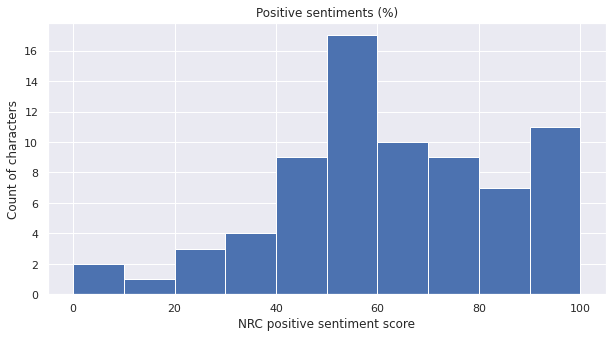

In [79]:
plt.figure(figsize=(10,5))
plt.hist(df_NRC.Positive_portion)
plt.title("Positive sentiments (%)")
plt.xlabel("NRC positive sentiment score")
plt.ylabel("Count of characters")
plt.show()

**Comparison of different characters' sentiments**

In [80]:
def grouped_bar_chart_for_characters_sentiments(characters_list):


    characters = []
    sentiments = []
    score = []
    
    for c in characters_list:
        
        positive = df_NRC[df_NRC.Name == c ].Positive_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Positive')
        score.append(positive)
        
        negative = df_NRC[df_NRC.Name == c ].Negative_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Negative')
        score.append(negative)


    # assign data of lists.  
    data = {'Name': characters, 'Sentiment': sentiments, 'Score': score}  

    # Create DataFrame  
    df_chars_sentiments = pd.DataFrame(data)     
    
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_sentiments, kind="bar",
        x="Name", y="Score", hue="Sentiment",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=10/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Sentiments")
    

def grouped_bar_chart_for_characters_emotions(characters_list):

    keys = []
    values = []
    characters = []

    for c in characters_list:
        d = df_NRC[df_NRC.Name == c ].Emotions_portion.tolist()[0]

        for item in d.items():
            characters.append(c), keys.append(item[0]), values.append(item[1])

    # assign data of lists.  
    data = {'Name': characters, 'Emotion': keys, 'Score': values}  

    # Create DataFrame  
    df_chars_emotions = pd.DataFrame(data)     
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_emotions, kind="bar",
        x="Name", y="Score", hue="Emotion",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=11.7/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Emotions")


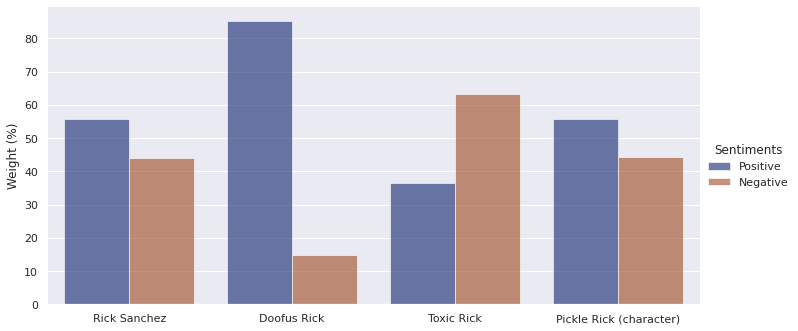

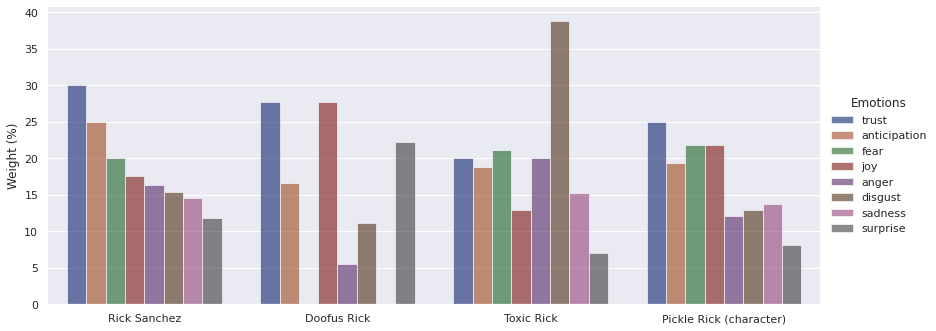

In [81]:
Ricks = ['Rick Sanchez', 'Doofus Rick', 'Toxic Rick', 'Pickle Rick (character)']
grouped_bar_chart_for_characters_sentiments(Ricks),
grouped_bar_chart_for_characters_emotions(Ricks)

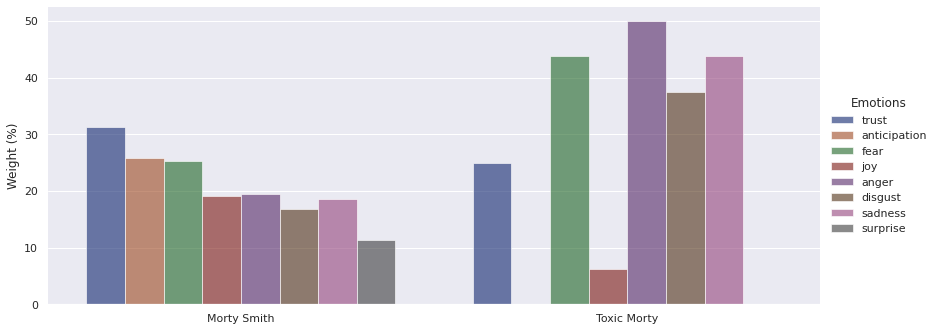

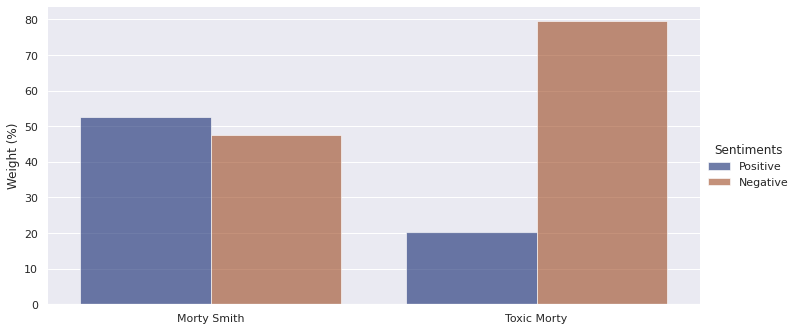

In [82]:
Mortys = ['Morty Smith', 'Toxic Morty']

grouped_bar_chart_for_characters_emotions(Mortys),
grouped_bar_chart_for_characters_sentiments(Mortys)

<a id='3.8.'></a>
## 3.8.  Sentiment Analysis: Episode

In [83]:
df_episode_transcript = df_transcripts.groupby(['season no.', 'episode no.', 'episode name'], as_index = False).agg({'line': ' '.join})
df_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name'], as_index = False).agg({'line': ' '.join})
df_episode_lines.line = df_episode_lines.line.apply(lambda x: remove_stopwords(x))
episodes_dialogue = df_episode_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]

In [84]:
def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ tk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    #Combine in a dict the weight of sentiments for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d

In [85]:
# Calculate the NRC sentiment score for each character

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_an_episode(aRow):
    if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(episodes_dialogue.keys()):
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
        
        count = 0
        for word in get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)



_ = df_episode_lines.apply(calculate_NRC_sentiment_of_an_episode, axis=1)


# store in dataframe of characters as a new column
df_episode_lines['NRC_score'] = sentiment_NRC_list
df_episode_lines['NRC_words'] = count_list
df_NRC_episodes = df_episode_lines[df_episode_lines.NRC_score.notnull()]
df_NRC_episodes = df_NRC_episodes[df_NRC_episodes.NRC_words != 0]

In [86]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_an_episode(aRow):
        
    dictEp = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_score'].values[0]
    
    positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
    negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
    keys = list(dictEp.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictEp[k] for k in keys}
    
    count = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_words'].values[0]
            
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


    
_ = df_NRC_episodes.apply(calculate_NRC_portions_of_an_episode, axis=1)

# store in dataframe of characters as a new column
df_NRC_episodes['Positive'] = positive_list
df_NRC_episodes['Positive_portion'] = positive_portion_list
df_NRC_episodes['Negative'] = negative_list
df_NRC_episodes['Negative_portion'] = negative_portion_list
df_NRC_episodes['Emotions'] = NRC_emotions_list
df_NRC_episodes['Emotions_portion'] = NRC_emotions_portion_list


In [87]:
# Plots for sentiments in an episode
   
def piechart_episode_sentiments(season, episode):
    
    labels = 'Positive', 'Negative'
    positive = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Positive'].values[0]
    negative = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Negative'].values[0]
    sizes = [positive, negative]
    plt.figure(figsize=(10,5))
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode) + ': Sentiments')

    

def plot_seaborn_episode_emotions(season, episode):
  
    d = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Emotions_portion'].tolist()[0]
    d = sort_dict(d)
    f, ax = plt.subplots() 
    y = list(d.keys())
    x = list(d.values())  # weight 
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Number of words')
    ax.invert_yaxis()  # labels read top-to-bottom
    #count_words = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['NRC_words'].values[0]
    #ax.set_title('Season ' + str(season) + ', Episode ' + str(episode)+ ': Emotions  (' + str(count_words) + ' NRC words)')
    name = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['episode name'].tolist()[0]
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode)+ ', Title = ' + name + ' : Emotions')
    ax.set_xlim([0, 100])
    ax.invert_yaxis() 

      
 



<Figure size 720x360 with 0 Axes>

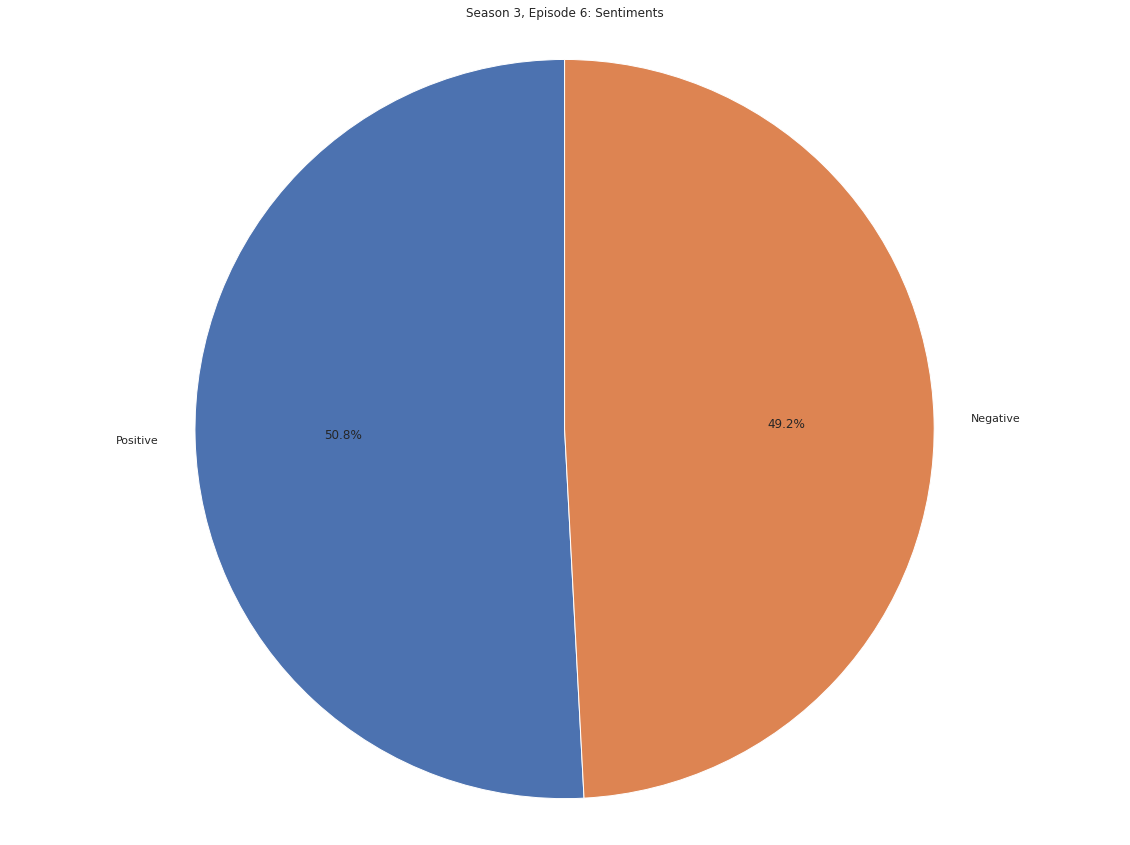

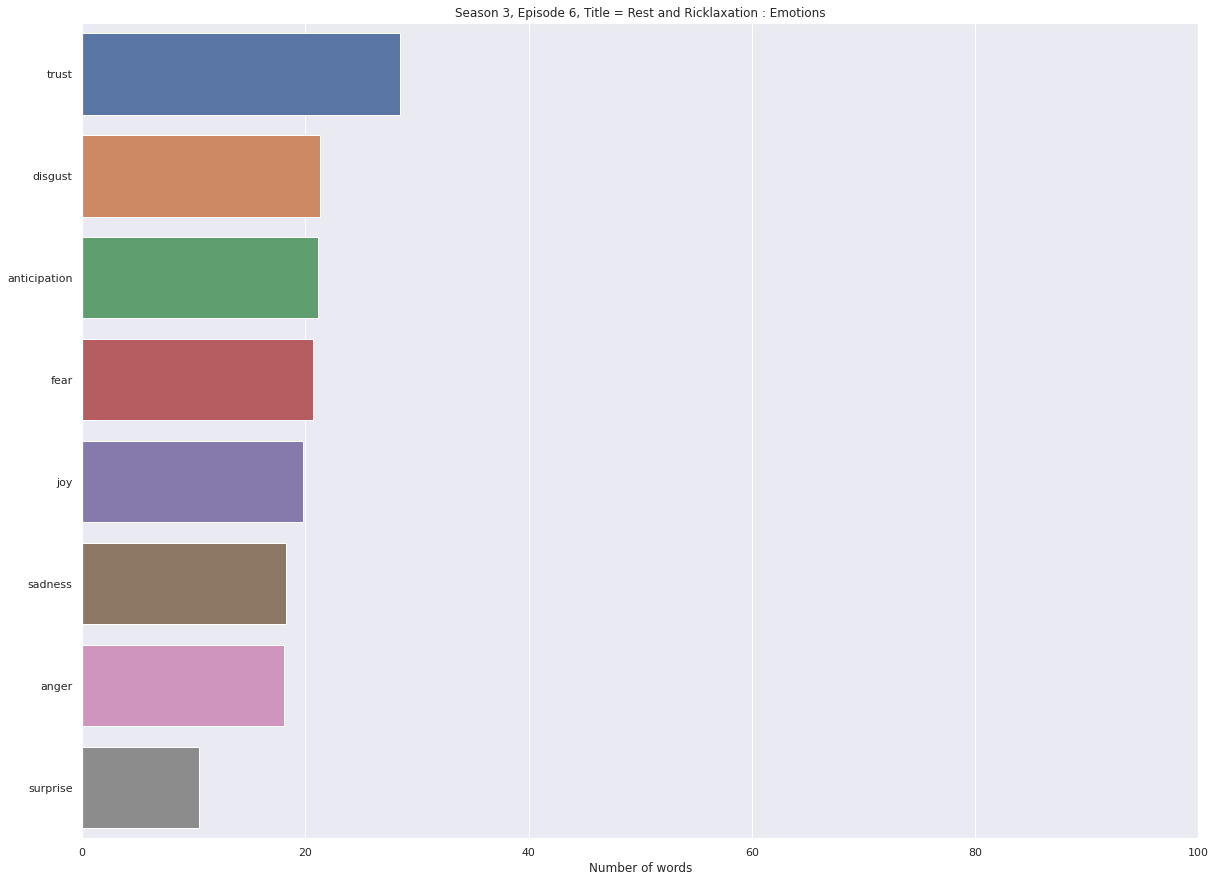

In [88]:
piechart_episode_sentiments(3,6),
plot_seaborn_episode_emotions(3,6)

**Sentiments through seasons**

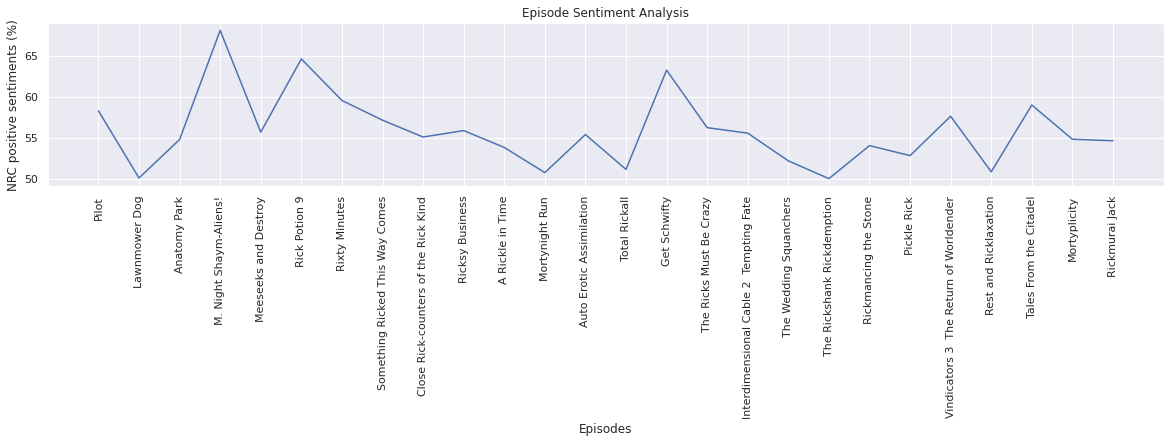

In [89]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_NRC_episodes['episode name'], df_NRC_episodes.Positive_portion)
plt.xticks(rotation=90)
plt.title("Episode Sentiment Analysis", )
plt.xlabel("Episodes")
plt.ylabel("NRC positive sentiments (%)")
plt.show()

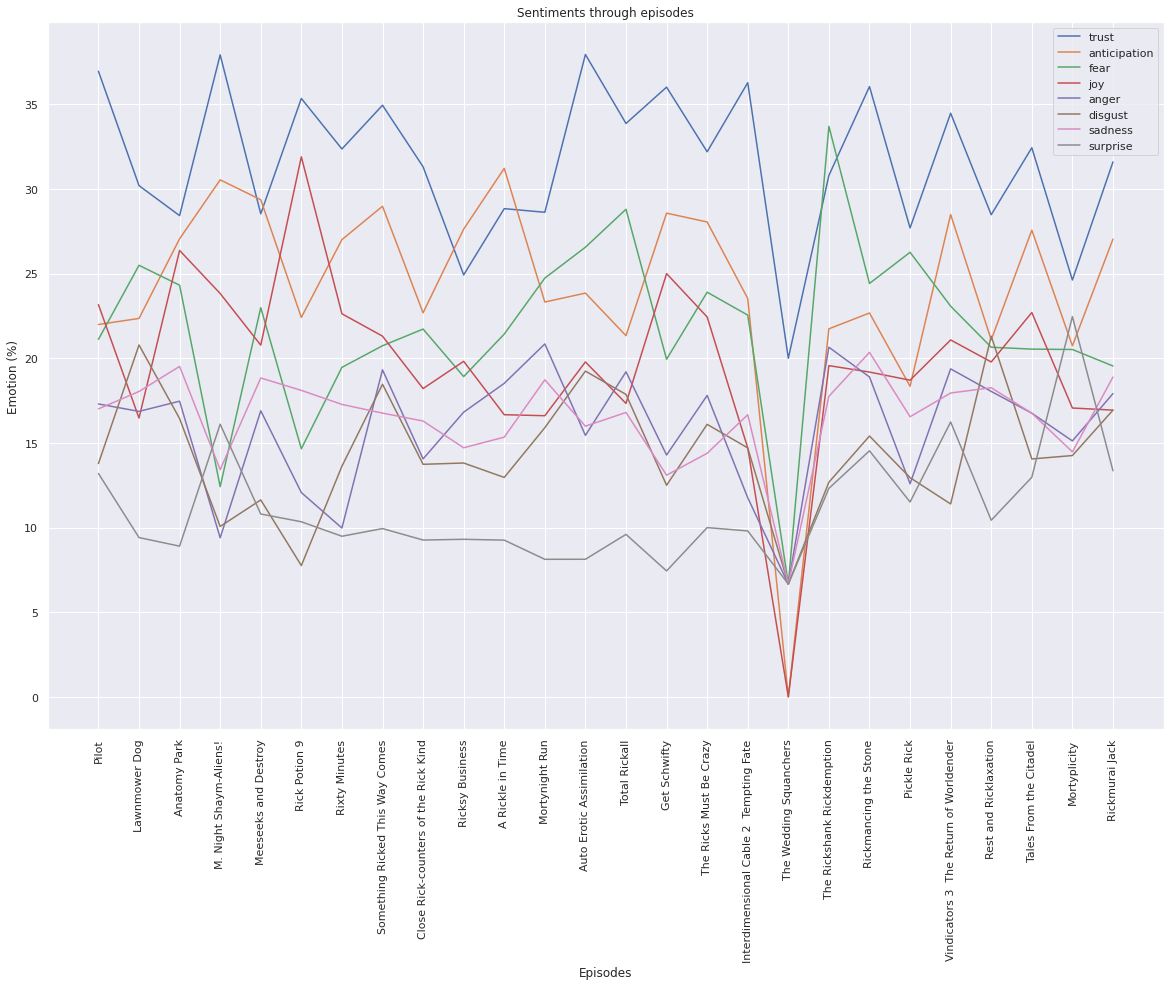

In [90]:
# Plot emotions
emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
plt.rcParams["figure.figsize"] = (20,13)
plt.rcParams["legend.loc"] = 'upper right'
    
for em in emotions:

    episodes = df_NRC_episodes['episode name']
        
    y = []
    for ep in episodes:
        y.append(df_NRC_episodes[df_NRC_episodes['episode name'] == ep].Emotions_portion.values[0][em])
                     
    plt.plot(episodes, y, label = em)
        
        
plt.xticks(rotation=90)
plt.title("Sentiments through episodes")
plt.xlabel("Episodes")
plt.ylabel("Emotion (%)")
plt.legend()
    
plt.show()

<a id='3.9.'></a>
## 3.9.  Sentiment Analysis of Characters Through Episodes

In [91]:
def character_evolvement_NRC(name): 
    
    
    df_char_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name', 'name'], as_index = False).agg({'line': ' '.join})
    df_char_episode_lines.line = df_char_episode_lines.line.apply(lambda x: remove_stopwords(x))
    
    df_aChar_lines = df_char_episode_lines[df_char_episode_lines.name == name ].drop('name', axis = 1)
    aChar_dialogue = df_aChar_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]
    sentiment_NRC_list = []
    count_list = []

    
    def calculate_NRC_sentiment_of_a_character_by_episode(aRow):
        if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(aChar_dialogue.keys()):
            sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
         #   print(sntiment_NRC)
            count = 0
            for word in get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
                if (word in list(df_nrc.word)):
                    count+=1


            sentiment_NRC_list.append(sentiment_NRC) 
            count_list.append(count)

        else:
            sentiment_NRC_list.append(None)
            count_list.append(None)


    _ = df_aChar_lines.apply(calculate_NRC_sentiment_of_a_character_by_episode, axis=1)


    # store in dataframe of characters as a new column
    df_aChar_lines['NRC_score'] = sentiment_NRC_list
    df_aChar_lines['NRC_words'] = count_list
    df_NRC_char_through_ep = df_aChar_lines[df_aChar_lines.NRC_score.notnull()]
    df_NRC_char_through_ep = df_NRC_char_through_ep[df_NRC_char_through_ep.NRC_words != 0]
        
        
    NRC_emotions_list = []
    positive_list = []
    negative_list = []
    positive_portion_list = []
    negative_portion_list = []
    NRC_emotions_portion_list = [] 
        
        
    def calculate_NRC_portions_of_a_character_through_episodes(aRow):
        
        dictEp = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_score'].values[0]
    
        positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
        negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
        keys = list(dictEp.keys())
        keys.remove('positive')
        keys.remove('negative')
        emotions_dict  =  { k: dictEp[k] for k in keys}

        count = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_words'].values[0]

        emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
        positive_portion = positive / (positive + negative) * 100
        negative_portion = negative / (positive + negative) * 100


        NRC_emotions_list.append(emotions_dict)
        NRC_emotions_portion_list.append(emotions_portion_dict)
        positive_list.append(positive)
        negative_list.append(negative)
        positive_portion_list.append(positive_portion)
        negative_portion_list.append(negative_portion)



    
    _ = df_NRC_char_through_ep.apply(calculate_NRC_portions_of_a_character_through_episodes, axis=1)

    # store in dataframe of characters as a new column
    df_NRC_char_through_ep['Positive'] = positive_list
    df_NRC_char_through_ep['Positive_portion'] = positive_portion_list
    df_NRC_char_through_ep['Negative'] = negative_list
    df_NRC_char_through_ep['Negative_portion'] = negative_portion_list
    df_NRC_char_through_ep['Emotions'] = NRC_emotions_list
    df_NRC_char_through_ep['Emotions_portion'] = NRC_emotions_portion_list
    
        

    # Plot sentiments 
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(df_NRC_char_through_ep['episode name'], df_NRC_char_through_ep.Positive_portion)
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("NRC positive sentiments (%)")
    plt.show()

    
    # Plot emotions
    emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams["legend.loc"] = 'upper right'
    
    for em in emotions:

        episodes = df_NRC_char_through_ep['episode name']
        
        y = []
        for ep in episodes:
            y.append(df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == ep].Emotions_portion.values[0][em])
                     
        plt.plot(episodes, y, label = em)
        
        
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Emotion (%)")
    plt.legend()
    
    plt.show()

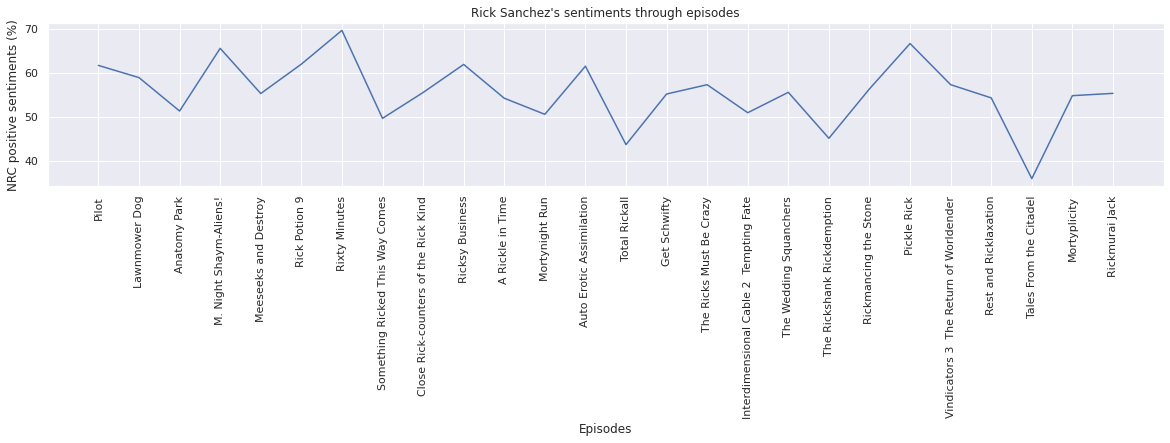

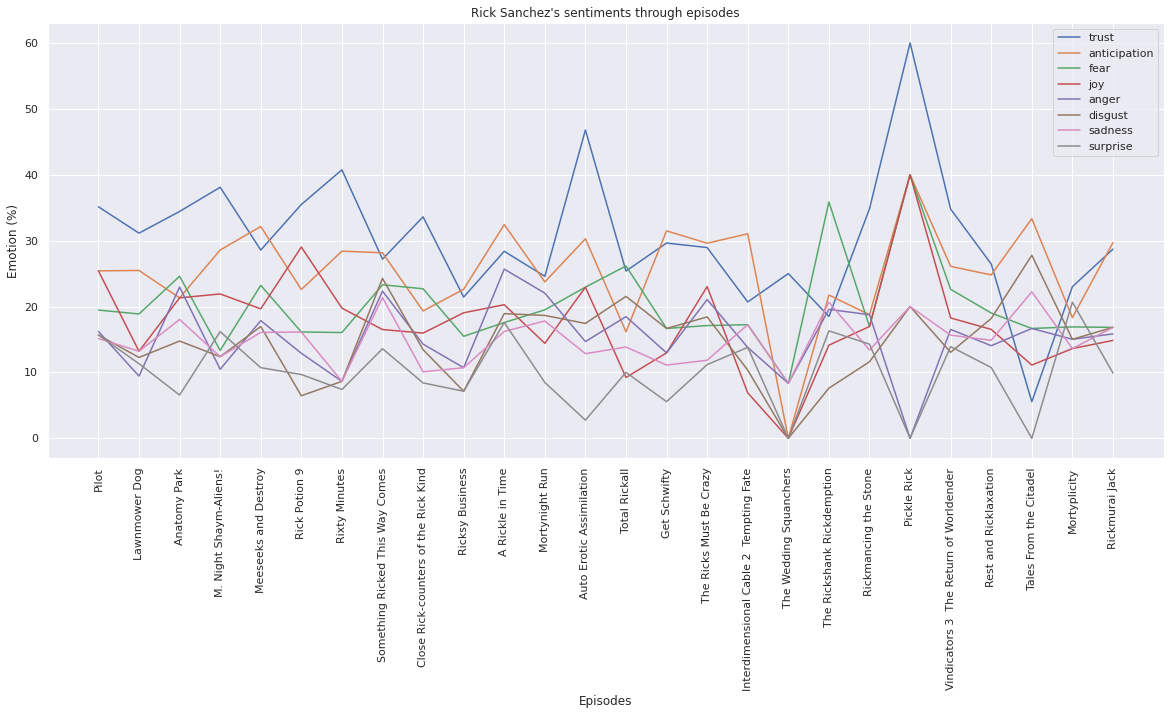

In [92]:
character_evolvement_NRC('Rick Sanchez')

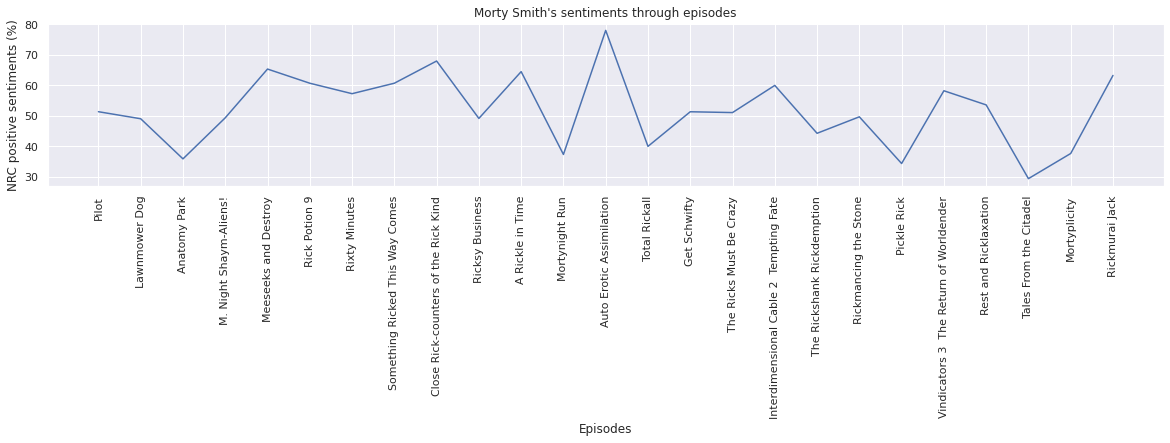

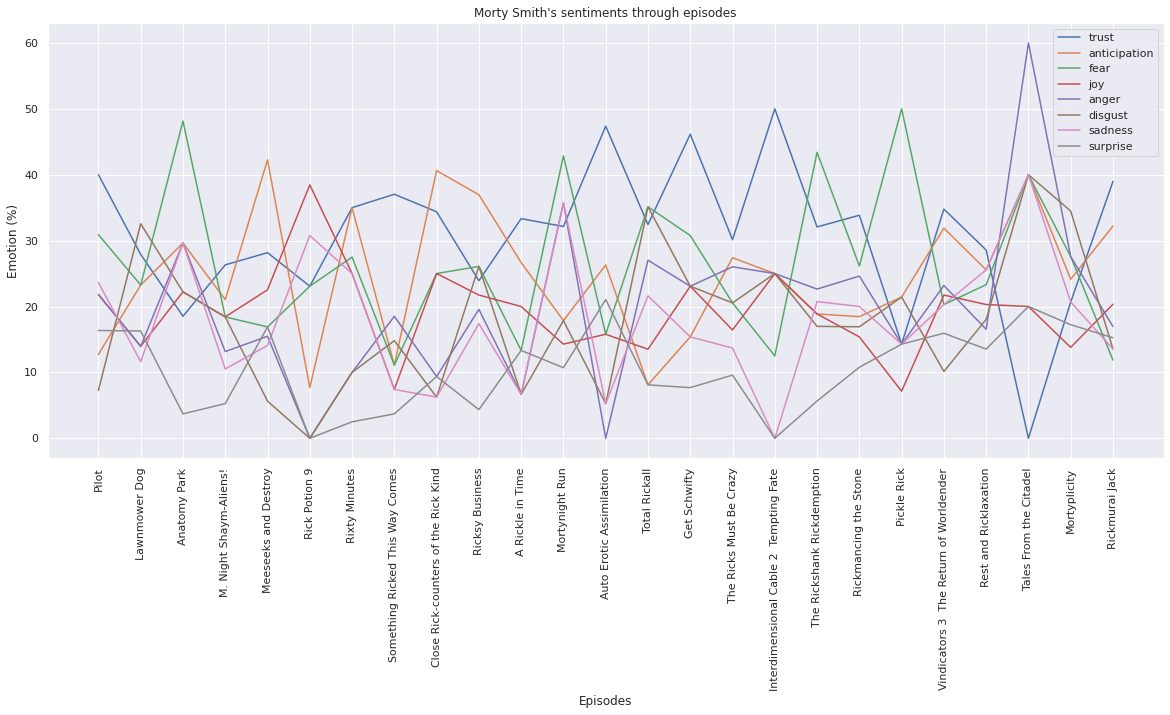

In [93]:
character_evolvement_NRC('Morty Smith')

<a id='4.'></a>
# 4. Discussion

Conclusively, Rick and Morty apart from a great series, is a real nice topic to investigate, since there are several perspectives that can be studied. To be more precise, the network of the series has a good amount of nodes and edges from which you can caclulate statistics, communities and focus on different properties/concept of networks. Moreover the series approach different topics starting from the daily life to disagreements between planets, so it was quite interesting to study the language, emotions. In general, we tried to apply many of the tools that we learn during the course this semester mainly focusing on communities and sentiment analysis, because the story of the series take place in multi-dimensional space and there a lot of different characters even for the same person (e.g. Ricks in different dimensions). missing ??? 

<a id='5.'></a>
# 5. Contribution


In [127]:
d = {'LAURINE DARGAUD' : ['', '', ':)', ':)', ':)', ':)', ':)', '', '', ''], 
     'ALEXANDRA POLYM' : ['', '', '', '', '', '', '', ':)', ':)', ':)'],
     'THOMAS SPYROU' : [':)', ':)', '', '', '', '', '', '', '', '']
     } 
  
ct = pd.DataFrame(d, index=['2', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9']) 

ct
# POLYM A.K.A POLYMENOPOULOU s212558
# Laurine Dargaud s212803 
# Thomas Spyrou s213161

,LAURINE DARGAUD,ALEXANDRA POLYM,THOMAS SPYROU
2,,,:)
3.1,,,:)
3.2,:),,
3.3,:),,
3.4,:),,
3.5,:),,
3.6,:),,
3.7,,:),
3.8,,:),
3.9,,:),


For the extraction, the cleaning and the preprocessing of the data we worked all together as well as on the presentaion of our results in the website. These stages are not contained in this notebook (code-wise), since the notebook would have been too long. However you can find most of the code on the GitHub repository.